# 피마 인디언 당뇨병 예측

피마 인디언 당뇨병 머신러닝 예측 모델을 수립하고, 평가 지표를 적용해 보세요.


1. 데이터를 로딩한 후 분포와 데이터를 확인해 보세요.

2. 당뇨병에 걸린 사람과 아닌 사람의 수는?

3. feature의 타입과 Null 개수를 살펴보세요.

4. 로지스틱 회귀를 이용해 예측 모델을 생성해 보세요.
get_clf_eval(), get_eval_by_threshold(), precision_recall_curve_plot()
를 이용해 성능 평가 지표를 출력하고 재현율 곡선을 시각화해 보세요.


5. 피처 값의 분포도를 살펴보시고,

6. 적절한 임곗값을 적용하여 예측 결과를 확인해 보세요.
==> 정확도, 정밀도, 재현율, f1, ROC AUC


========== 주요변수 =======================================

Glucose: 포도당 부하 검사 수치
BloodPressure: 혈압(mm Hg)
SkinThickness: 팔 삼두근 뒤쪽의 피하지방 측정값(mm)
Insulin: 혈청 인슐린(mu U/ml)
BMI: 체질량지수(체중(kg)/(키(m))^2)
DiabetesPedigreeFunction: 당뇨 내력 가중치 값
Age: 나이
Outcome: 클래스 결정 값(0또는 1)

In [1]:
%load_ext watermark
%watermark -v -p sklearn,numpy,scipy,matplotlib

from preamble import *
plt.rcParams['image.cmap'] = "gray"
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import platform

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

path = "c:/Windows/Fonts/malgun.ttf"
from matplotlib import font_manager, rc
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system... sorry~~~~')    

plt.rcParams['axes.unicode_minus'] = False

CPython 3.7.3
IPython 7.6.1

sklearn 0.22
numpy 1.16.4
scipy 1.4.1
matplotlib 3.1.0


# Plots 라이브러리

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.tools as tls
import plotly.figure_factory as ff
import plotly.express as px
py.init_notebook_mode(connected=True)
import squarify

# Data processing, metrics and modeling

In [3]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_curve, precision_recall_curve, accuracy_score, roc_auc_score
import lightgbm as lgbm
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from yellowbrick.classifier import DiscriminationThreshold

# Stats

In [4]:
import scipy.stats as ss
from scipy import interp
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

# Time

In [5]:
from contextlib import contextmanager
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [6]:
data=pd.read_csv('../../data/diabetes.csv',index_col=False)
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,...,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,...,33.6,0.63,50,1
1,1,85,66,29,...,26.6,0.35,31,0
2,8,183,64,0,...,23.3,0.67,32,1
3,1,89,66,23,...,28.1,0.17,21,0
4,0,137,40,35,...,43.1,2.29,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,...,32.9,0.17,63,0
764,2,122,70,27,...,36.8,0.34,27,0
765,5,121,72,23,...,26.2,0.24,30,0
766,1,126,60,0,...,30.1,0.35,47,1


In [7]:
not_zero_data = data[(data['Outcome'] != 0)]
include_zero_data = data[(data['Outcome'] == 0)]

### 0값을 NaN 값으로 바꿔준다.

In [8]:
data[['Glucose','BloodPressure',
      'SkinThickness','Insulin','BMI']] = data[['Glucose','BloodPressure',
                                                'SkinThickness','Insulin','BMI']].replace(0,np.NaN)
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,...,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,...,33.6,0.63,50,1
1,1,85.0,66.0,29.0,...,26.6,0.35,31,0
2,8,183.0,64.0,NaN,...,23.3,0.67,32,1
3,1,89.0,66.0,23.0,...,28.1,0.17,21,0
4,0,137.0,40.0,35.0,...,43.1,2.29,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101.0,76.0,48.0,...,32.9,0.17,63,0
764,2,122.0,70.0,27.0,...,36.8,0.34,27,0
765,5,121.0,72.0,23.0,...,26.2,0.24,30,0
766,1,126.0,60.0,NaN,...,30.1,0.35,47,1


## NaN을 통해 각 feature별로 빠진 데이터가 얼마나되는지 확인한다.

In [9]:
null_feat = pd.DataFrame(len(data['Outcome']) - data.isnull().sum(), 
                         columns = ['Count'])

percentage_null = pd.DataFrame(((len(data['Outcome']) - (null_feat['Count']))/len(data['Outcome']))*100, 
                               columns = ['Count'])
percentage_null = percentage_null.round(2)

trace = go.Bar(x = null_feat.index, 
               y = null_feat['Count'],
               opacity = 0.8, 
               text = percentage_null['Count'],  
               textposition = 'auto',
               marker=dict(color = '#7EC0EE',
                           line  =  dict(color='#000000',width=1.5)))

layout = dict(title =  "Missing Values (count & %)")

fig = dict(data = [trace], layout=layout)
py.iplot(fig)

#### Missing values :

#### Insulin = 48.7% - 374
#### SkinThickness = 29.56% - 227
#### BloodPressure = 4.56% - 35
#### BMI = 1.43% - 11
#### Glucose = 0.65% - 5

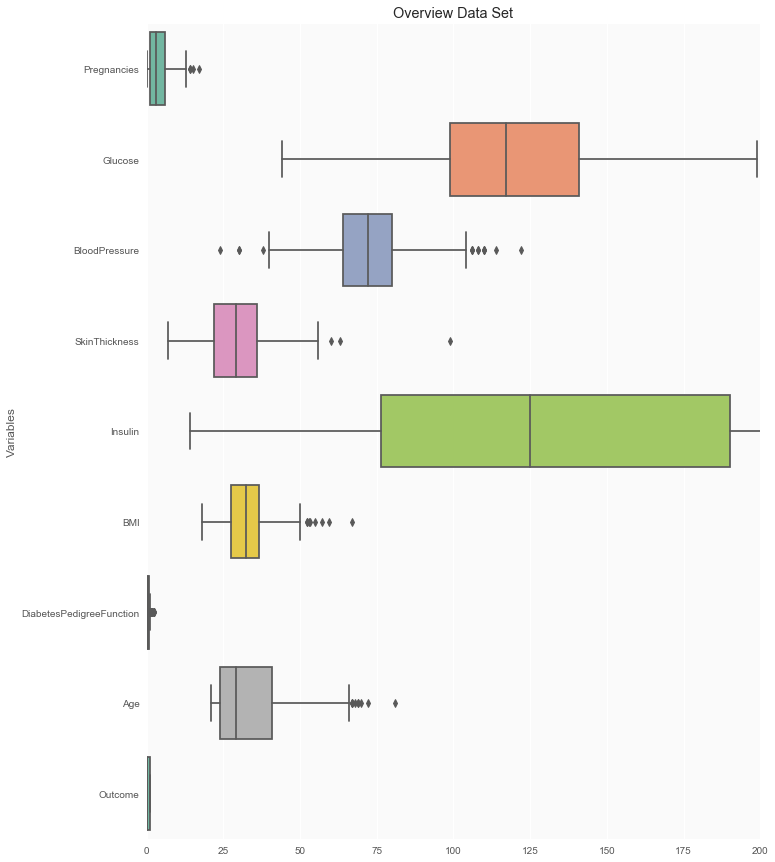

In [10]:
plt.style.use('ggplot') # Using ggplot2 style visuals 

f, ax = plt.subplots(figsize=(11, 15))

ax.set_facecolor('#fafafa')
ax.set(xlim=(-.05, 200))
plt.ylabel('Variables')
plt.title("Overview Data Set")
ax = sns.boxplot(data = data, 
  orient = 'h', 
  palette = 'Set2')

# target 값과 feature들간의 상관관계를 알아본다.

In [11]:
#correlation
correlation = data.corr()
#tick labels
matrix_cols = correlation.columns.tolist()
#convert to array
corr_array  = np.array(correlation)
trace = go.Heatmap(z = corr_array,
                   x = matrix_cols,
                   y = matrix_cols,
                   colorscale='RdYlGn_r',
                   colorbar   = dict())
layout = go.Layout(dict(title = 'Correlation Matrix for variables',
                        #autosize = False,
                        #height  = 1400,
                        #width   = 1600,
                        margin  = dict(r = 0,l = 100,
                                       t = 0,b = 100),
                        yaxis   = dict(tickfont = dict(size = 9)),
                        xaxis   = dict(tickfont = dict(size = 9))))
fig = go.Figure(data = [trace],layout = layout)
py.iplot(fig)

## feature 별 메디안 구하는 함수 정의
## 1. 당뇨병인 사람들 median
## 2. 건강한 사람들 median을
## groupby로 나눈 후 median 값을 각각 구한다.

In [12]:
def median_target(var):   
    temp = data[data[var].notnull()]
    temp = temp[[var, 'Outcome']].groupby(['Outcome'])[[var]].median().reset_index()
    return temp

## 각 feature별 건강한 사람과 당뇨병 환자 분포도 함수 정의

In [13]:
def plot_distribution(data_select, size_bin) :  
    # 2 datasets
    tmp1 = not_zero_data[data_select]           # not_zero_data = data[(data['Outcome'] != 0)]
    tmp2 = include_zero_data[data_select]       # include_zero_data = data[(data['Outcome'] == 0)]
    hist_data = [tmp1, tmp2]
    
    group_labels = ['diabetic', 'healthy']
    colors = ['#FFD700', '#7EC0EE']

    fig = ff.create_distplot(hist_data, 
                             group_labels, 
                             colors = colors, 
                             show_hist = True, 
                             bin_size = size_bin, 
                             curve_type='kde')
    
    fig['layout'].update(title = data_select)

    py.iplot(fig, filename = 'Density plot')

# 1. Insulin NaN 치환

In [14]:
plot_distribution('Insulin', 0)

In [15]:
median_target('Insulin')

,Outcome,Insulin
0,0,102.5
1,1,169.5


In [16]:
data.loc[(data['Outcome'] == 0 ) & (data['Insulin'].isnull()), 'Insulin'] = 102.5
data.loc[(data['Outcome'] == 1 ) & (data['Insulin'].isnull()), 'Insulin'] = 169.5

# 2. Glucose NaN 치환

In [17]:
plot_distribution('Glucose', 0)

In [18]:
median_target('Glucose')

,Outcome,Glucose
0,0,107.0
1,1,140.0


In [19]:
data.loc[(data['Outcome'] == 0 ) & (data['Glucose'].isnull()), 'Glucose'] = 107
data.loc[(data['Outcome'] == 1 ) & (data['Glucose'].isnull()), 'Glucose'] = 140

# 3. SkinThickness NaN 치환

In [20]:
plot_distribution('SkinThickness', 10)

In [21]:
median_target('SkinThickness')

,Outcome,SkinThickness
0,0,27.0
1,1,32.0


In [22]:
data.loc[(data['Outcome'] == 0 ) & (data['SkinThickness'].isnull()), 'SkinThickness'] = 27
data.loc[(data['Outcome'] == 1 ) & (data['SkinThickness'].isnull()), 'SkinThickness'] = 32

# 4. BloodPressure NaN 치환

In [23]:
plot_distribution('BloodPressure', 5)

In [24]:
median_target('BloodPressure')

,Outcome,BloodPressure
0,0,70.0
1,1,74.5


In [25]:
data.loc[(data['Outcome'] == 0 ) & (data['BloodPressure'].isnull()), 'BloodPressure'] = 70
data.loc[(data['Outcome'] == 1 ) & (data['BloodPressure'].isnull()), 'BloodPressure'] = 74.5

# 5. BMI NaN 치환

In [26]:
plot_distribution('BMI', 0)

In [27]:
median_target('BMI')

,Outcome,BMI
0,0,30.1
1,1,34.3


In [28]:
data.loc[(data['Outcome'] == 0 ) & (data['BMI'].isnull()), 'BMI'] = 30.1
data.loc[(data['Outcome'] == 1 ) & (data['BMI'].isnull()), 'BMI'] = 34.3

# plot distribution
## 나머지 feature plot

In [29]:
plot_distribution('Age', 0)
plot_distribution('Pregnancies', 0)
plot_distribution('DiabetesPedigreeFunction', 0)

# NaN 값을 당뇨병 / 건강한 사람별로 나눠서 median 줘서 전부 채움.

In [30]:
null_feat = pd.DataFrame(len(data['Outcome']) - data.isnull().sum(), 
                         columns = ['Count'])

percentage_null = pd.DataFrame(((len(data['Outcome']) - (null_feat['Count']))/len(data['Outcome']))*100, 
                               columns = ['Count'])
percentage_null = percentage_null.round(2)

trace = go.Bar(x = null_feat.index, 
               y = null_feat['Count'],
               opacity = 0.8, 
               text = percentage_null['Count'],  
               textposition = 'auto',
               marker=dict(color = '#7EC0EE',
                           line  =  dict(color='#000000',width=1.5)))

layout = dict(title =  "Missing Values (count & %)")

fig = dict(data = [trace], layout=layout)
py.iplot(fig)

### ** 오차행렬, 정확도, 정밀도, 재현율을 한꺼번에 계산하는 함수 생성 **

In [31]:
from sklearn.metrics import accuracy_score, precision_score , recall_score , confusion_matrix

def get_clf_eval(y_test , pred):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    print('오차 행렬')
    print(confusion)
    models = pd.DataFrame({'Evaluation': ['정확도','정밀도','재현율'],
                            'Score': [accuracy, precision, recall]})
    print(models.sort_values(by='Score', ascending=False))

# X_train, X_test, y_train, y_test로 분리

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator
from sklearn.linear_model import LogisticRegression

X=data.drop('Outcome',axis=1)
y=data['Outcome']
X_train, X_test, y_train, y_test=train_test_split(X, 
                                                  y,
                                                  random_state=0)

lr_clf = LogisticRegression()

lr_clf.fit(X_train , y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test , pred)

오차 행렬
[[117  13]
 [ 29  33]]
  Evaluation  Score
0        정확도   0.78
1        정밀도   0.72
2        재현율   0.53


## Precision/Recall Trade-off

In [33]:
pred_proba = lr_clf.predict_proba(X_test)
pred  = lr_clf.predict(X_test)
print('pred_proba()결과 Shape : {0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출 \n:', pred_proba[:3])

# 예측 확률 array 와 예측 결과값 array 를 concatenate 하여 예측 확률과 결과값을 한눈에 확인
pred_proba_result = np.concatenate([pred_proba , pred.reshape(-1,1)],axis=1)
print('두개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n',pred_proba_result[:3])

pred_proba()결과 Shape : (192, 2)
pred_proba array에서 앞 3개만 샘플로 추출 
: [[0.053 0.947]
 [0.866 0.134]
 [0.922 0.078]]
두개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.053 0.947 1.   ]
 [0.866 0.134 0.   ]
 [0.922 0.078 0.   ]]


## ** Binarizer 활용 **
### ** 분류 결정 임계값 0.5 기반에서 Binarizer를 이용하여 예측값 변환 **

In [34]:
from sklearn.preprocessing import Binarizer
thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]

def get_eval_by_threshold(y_test , pred_proba_c1, thresholds):
    # thresholds list객체내의 값을 차례로 iteration하면서 Evaluation 수행.
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1) 
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:',custom_threshold)
        get_clf_eval(y_test , custom_predict)
            

get_eval_by_threshold(y_test ,pred_proba[:,1].reshape(-1,1), thresholds )

임곗값: 0.4
오차 행렬
[[109  21]
 [ 21  41]]
  Evaluation  Score
0        정확도   0.78
1        정밀도   0.66
2        재현율   0.66
임곗값: 0.45
오차 행렬
[[113  17]
 [ 26  36]]
  Evaluation  Score
0        정확도   0.78
1        정밀도   0.68
2        재현율   0.58
임곗값: 0.5
오차 행렬
[[117  13]
 [ 29  33]]
  Evaluation  Score
0        정확도   0.78
1        정밀도   0.72
2        재현율   0.53
임곗값: 0.55
오차 행렬
[[120  10]
 [ 29  33]]
  Evaluation  Score
0        정확도   0.80
1        정밀도   0.77
2        재현율   0.53
임곗값: 0.6
오차 행렬
[[122   8]
 [ 30  32]]
  Evaluation  Score
0        정확도   0.80
1        정밀도   0.80
2        재현율   0.52


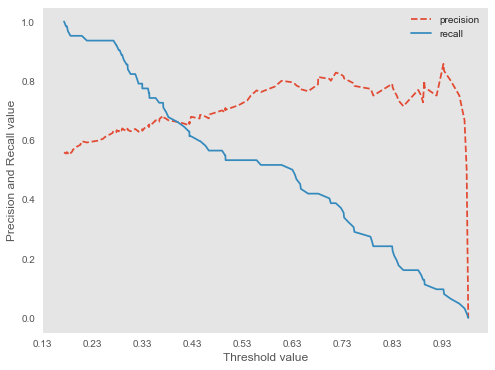

In [35]:
from sklearn.metrics import precision_recall_curve
def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    
precision_recall_curve_plot( y_test, lr_clf.predict_proba(X_test)[:, 1] )

# F1 Score

In [36]:
from sklearn.metrics import f1_score 
f1 = f1_score(y_test , pred)
print('F1 스코어: {0:.4f}'.format(f1))

F1 스코어: 0.6111


In [37]:
def get_clf_eval(y_test , pred):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    print('오차 행렬')
    print(confusion)
    models = pd.DataFrame({'Evaluation': ['정확도','정밀도','재현율','f1'],
                            'Score': [accuracy, precision, recall,f1]})
    print(models.sort_values(by='Score', ascending=False))
    
thresholds = [0.4 , 0.45 , 0.50 , 0.55 , 0.60]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)    

임곗값: 0.4
오차 행렬
[[109  21]
 [ 21  41]]
  Evaluation  Score
0        정확도   0.78
1        정밀도   0.66
2        재현율   0.66
3         f1   0.66
임곗값: 0.45
오차 행렬
[[113  17]
 [ 26  36]]
  Evaluation  Score
0        정확도   0.78
1        정밀도   0.68
3         f1   0.63
2        재현율   0.58
임곗값: 0.5
오차 행렬
[[117  13]
 [ 29  33]]
  Evaluation  Score
0        정확도   0.78
1        정밀도   0.72
3         f1   0.61
2        재현율   0.53
임곗값: 0.55
오차 행렬
[[120  10]
 [ 29  33]]
  Evaluation  Score
0        정확도   0.80
1        정밀도   0.77
3         f1   0.63
2        재현율   0.53
임곗값: 0.6
오차 행렬
[[122   8]
 [ 30  32]]
  Evaluation  Score
0        정확도   0.80
1        정밀도   0.80
3         f1   0.63
2        재현율   0.52


# ROC Curve와 AUC

In [38]:
from sklearn.metrics import roc_curve

# 레이블 값이 1일때의 예측 확률을 추출 
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1] 

fprs , tprs , thresholds = roc_curve(y_test, pred_proba_class1)
# 반환된 임곗값 배열 로우가 47건이므로 샘플로 10건만 추출하되, 임곗값을 5 Step으로 추출. 
thr_index = np.arange(0, thresholds.shape[0], 5)
print('샘플 추출을 위한 임곗값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값: ', np.round(thresholds[thr_index], 2))

# 5 step 단위로 추출된 임계값에 따른 FPR, TPR 값
print('샘플 임곗값별 FPR: ', np.round(fprs[thr_index], 3))
print('샘플 임곗값별 TPR: ', np.round(tprs[thr_index], 3))

샘플 추출을 위한 임곗값 배열의 index 10개: [ 0  5 10 15 20 25 30 35 40 45 50 55]
샘플용 10개의 임곗값:  [1.98 0.89 0.72 0.57 0.49 0.42 0.36 0.33 0.3  0.28 0.21 0.01]
샘플 임곗값별 FPR:  [0.    0.023 0.038 0.077 0.115 0.154 0.177 0.215 0.231 0.254 0.308 1.   ]
샘플 임곗값별 TPR:  [0.    0.129 0.387 0.516 0.565 0.613 0.742 0.774 0.855 0.903 0.952 1.   ]


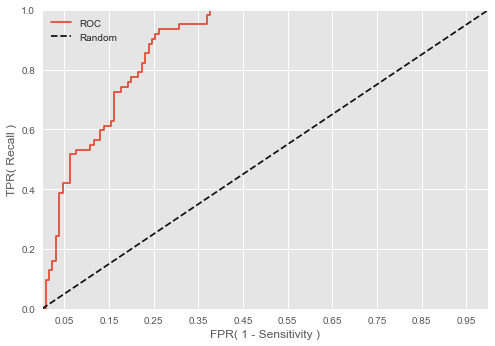

In [39]:
def roc_curve_plot(y_test , pred_proba_c1):
    # 임곗값에 따른 FPR, TPR 값을 반환 받음. 
    fprs , tprs , thresholds = roc_curve(y_test ,pred_proba_c1)

    # ROC Curve를 plot 곡선으로 그림. 
    plt.plot(fprs , tprs, label='ROC')
    # 가운데 대각선 직선을 그림. 
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    
    # FPR X 축의 Scale을 0.1 단위로 변경, X,Y 축명 설정등   
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel('FPR( 1 - Sensitivity )'); plt.ylabel('TPR( Recall )')
    plt.legend()
    plt.show()
    
roc_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1] )

In [40]:
from sklearn.metrics import roc_auc_score

pred_proba = lr_clf.predict_proba(X_test)[:, 1]
roc_score = roc_auc_score(y_test, pred_proba)
print('ROC AUC 값: {0:.4f}'.format(roc_score))

ROC AUC 값: 0.8829
